<a href="https://colab.research.google.com/github/SaxMan96/GitHub-Repos-BigData/blob/master/Copy_of_data_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Constraints

In [77]:
%matplotlib inline
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from collections import Counter
import category_encoders as ce
import matplotlib.pylab as plt
from matplotlib.ticker import MaxNLocator
import datetime as dt
import time
MAY_14TH = 1557850923.935756

# Defines

In [56]:
def load_data() -> pd.Series:
    csv = pd.read_csv('result.csv', sep=",")
    return csv

def del_nans(nans_perc):
    global csv, nans
    na = csv.isna().sum()
    del_na = na[na >= nans_perc*len(csv)]
    csv = csv.drop(del_na.index.values, axis=1)
    nans = nans_ctr()
    
def nans_ctr() -> pd.Series:
    return csv.isna().sum()

def unique_ctr() -> pd.Series():
    unique = pd.Series()
    for col in list(csv_org):
        if(csv.columns.contains(col) and (col != 'train')):
            unique.at[col] = len(csv[col].unique())
    return unique

def val_types() -> pd.Series():
    val_type = pd.Series()
    for col in list(csv_org):
        if not csv.columns.contains(col) or col == 'train':
            continue
        if csv[col].dtype == np.float64:
            val_type.at[col] = np.float64
        elif csv[col].dtype == np.int64:
            val_type.at[col] = np.int64
        elif csv[col].dtype == np.int32:
            val_type.at[col] = np.int32
        elif csv[col].dtype == bool:
            val_type.at[col] = bool
        elif csv[col].dtype == object:
            val_type.at[col] = object
        else:
            print(f"No common value type found in val_types() - {csv[col].dtype}")
    return val_type

def stat(f):
    nans = nans_ctr()
    unique = unique_ctr()
    val_type = val_types()
    print(f"min: {csv[f].min()}")
    print(f"max: {csv[f].max()}")
    print(f"nans: {nans[f]}")
    print(f"unique: {unique[f]}")
    print(f"val_type: {val_type[f]}")
    print(f"vals per class: {round((len(csv)-nans[f])/unique[f],2)}")
    
def plot(data, sort=False, log=True, small=False, fontsize=7):
    if small:
        figsize = (8,4)
    else:
        figsize = (20,10)
    letter_counts = Counter(data)
    df = pd.DataFrame.from_dict(letter_counts, orient='index')
    if sort:
        ax = df.sort_values(by=0, ascending=False).plot(kind='bar', logy = log, figsize=figsize, legend=False)
    else:
        ax = df.plot(kind='bar', logy = log, figsize=figsize, legend=False)
    plt.xticks(fontsize=fontsize, rotation=90)
    plt.show()
    
def threshold_factorization(data, *t_list) -> pd.Series():
    letter_counts = Counter(data)
    df = pd.DataFrame.from_dict(letter_counts, orient='index')
    df = df.sort_values(by=0, ascending=False)
    t_list = (df.values[0].item()+1,) + t_list + (0,)
    out = data.copy()
    for i in tqdm(range(1,len(t_list)),desc="Progress",leave=False):
        idx = df[(df>t_list[i]).values & (df<=t_list[i-1]).values].index
        for j in tqdm(idx,leave=False):
            out.loc[out == j] = i
    return out

def factorize(data) -> pd.Series():
    series = data.copy()
    labels, _ = pd.factorize(series)
    series = labels[:len(series)]
    return series

def cast(data, lower_t, upper_t) -> pd.Series():
    data = data.sort_values()
    data[data<lower_t] = lower_t
    data[data>upper_t] = upper_t
    return data

def standarize(df) ->pd.Series():
    return round((df-df.min())/(df.max()-df.min()),4)

def one_hot_encoding(f):
    global csv
    ohe = ce.OneHotEncoder(cols = [f], handle_unknown='ignore', use_cat_names=True)
    csv[f] = csv[f].fillna(-1)
    new_features = ohe.fit_transform(csv[f].to_frame())
    csv = csv.drop([f],axis=1)
    csv = pd.concat([csv,new_features],axis=1)
    
def binary_encoding(f):
    global csv
    ohe = ce.BinaryEncoder(cols = [f], handle_unknown='ignore',drop_invariant=True)
    csv[f] = csv[f].fillna(-1)
    new_features = ohe.fit_transform(csv[f].to_frame())
    csv = csv.drop([f],axis=1)
    csv = pd.concat([csv,new_features],axis=1)  
def delete(f):
    global csv
    csv[f] = csv_org[f]
    csv = csv.drop(f, axis=1)

In [57]:
def drop_pushedAt_nans(df):
    """Drops records where pushedAt is NaN"""
    isna = pd.isna(df['pushedAt'])
    isna = isna[isna].index
    return df.drop(isna, axis=0)
  
def fix_negative_time(df):
    """Fix rows where pushedAt is earlier than createdAt (mostly case for forks)"""
    
    neg_time = (pd.to_datetime(df['pushedAt']) - pd.to_datetime(df['createdAt'])).dt.days < 0
    neg_time = neg_time[neg_time].index
    df.loc[neg_time, 'pushedAt'] = df.loc[neg_time, 'createdAt']
    return df

def create_repoage_column(df):
    """Creates RepoAge column (in days)"""
    
    df['RepoAge'] = MAY_14TH - pd.to_datetime(df['pushedAt']).apply(lambda x: x.value / 1000000000)
    df['RepoAge'] = (df['RepoAge'] / 60 / 60 / 24).astype(int)
    return df

def create_label_column(df):
    """Creates label column (whether or not there was a push in last 3 months)"""
    
    df['label'] = (MAY_14TH - pd.to_datetime(df['pushedAt']).apply(lambda x: x.value / 1000000000)) / 60 / 60 / 24
    df['label'] = (df['label'] < 90).astype(int)
    return df

# Data Loading

In [58]:
csv = load_data()
csv_org = csv.copy()
nans = nans_ctr()
unique = unique_ctr()
val_type = val_types()
print("Columns left after Nans removed: ", len(csv.columns))

C:\Users\Mateusz\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3214: DtypeWarning: Columns (190,191) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


Columns left after Nans removed:  221


# Data Preprocessing

In [59]:
csv = drop_pushedAt_nans(csv)
csv = fix_negative_time(csv)
csv = create_repoage_column(csv)
csv = create_label_column(csv)

In [60]:
languages = list(("NewLisp", "Max", "Liquid", "SQLPL", "Perl", "M4", "OpenEdge ABL", "XS", "Xtend", "Mirah", "SMT", "Prolog", "Ioke", "Crystal", "Haskell", "PureBasic", "Ragel in Ruby Host", "Rich Text Format", "Dockerfile", "Processing", "Erlang", "DIGITAL Command Language", "Roff", "Haxe", "Objective-J", "PLSQL", "ApacheConf", "Gnuplot", "COBOL", "Fortran", "GAP", "UnrealScript", "IDL", "Common Lisp", "PHP", "Python", "HTML", "sed", "Pascal", "C", "VCL", "Rebol", "Clojure", "PLpgSQL", "Jupyter Notebook", "Protocol Buffer", "Gherkin", "JSONiq", "Coq", "M", "HLSL", "Mathematica", "Puppet", "JavaScript", "Scheme", "MoonScript", "Scala", "Slash", "Vue", "Elixir", "SaltStack", "Yacc", "Perl 6", "Chapel", "Nim", "DM", "Batchfile", "AppleScript", "HCL", "Nu", "Ada", "C#", "Scilab", "TypeScript", "AspectJ", "SuperCollider", "F#", "CMake", "Handlebars", "LiveScript", "Clean", "Cool", "Mercury", "AGS Script", "Thrift", "POV-Ray SDL", "Inno Setup", "PigLatin", "Nginx", "Io", "Groovy", "ANTLR", "SystemVerilog", "Racket", "XSLT", "Boo", "CSS", "NSIS", "Rouge", "Mako", "ASP", "EmberScript", "R", "API Blueprint", "Rust", "XProc", "LLVM", "Shell", "PowerShell", "RobotFramework", "Pure Data", "Nemerle", "QML", "GCC Machine Description", "Forth", "Objective-C++", "ShaderLab", "OpenSCAD", "ooc", "Limbo", "Tcl", "Visual Basic", "Alloy", "Logos", "Gosu", "GLSL", "Verilog", "Arc", "Dart", "Cuda", "Pike", "Smarty", "Terra", "Stata", "Java", "ActionScript", "Hy", "Groff", "CoffeeScript", "Arduino", "xBase", "Ragel", "Graphviz (DOT)", "Objective-C", "Lex", "NetLogo", "Game Maker Language", "E", "Swift", "QMake", "Web Ontology Language", "Vim script", "Jsonnet", "RPC", "Go", "RenderScript", "Awk", "Metal", "Turing", "ColdFusion", "Eagle", "Smalltalk", "OCaml", "DTrace", "Lua", "Julia", "XQuery", "Vala", "Makefile", "Bison", "Brainfuck", "Assembly", "FreeMarker", "D", "TeX", "PostScript", "MATLAB", "GDB", "Kotlin", "SourcePawn", "Ruby", "AutoHotkey", "Emacs Lisp", "AutoIt", "HyPhy", "C++", "J", "VHDL", "Standard ML"))

In [62]:
popularLanguages=[]
for l in languages:
    if round(100*(1-nans[l]/len(csv.index)))>5.0:
        print(l, "\t", round(100*(1-nans[l]/len(csv.index))),"%")
        popularLanguages.append(l)
print(popularLanguages)

Python 	 37.0 %
HTML 	 16.0 %
C 	 13.0 %
JavaScript 	 25.0 %
CMake 	 6.0 %
CSS 	 15.0 %
Shell 	 27.0 %
Java 	 8.0 %
Makefile 	 12.0 %
Ruby 	 8.0 %
C++ 	 15.0 %
['Python', 'HTML', 'C', 'JavaScript', 'CMake', 'CSS', 'Shell', 'Java', 'Makefile', 'Ruby', 'C++']


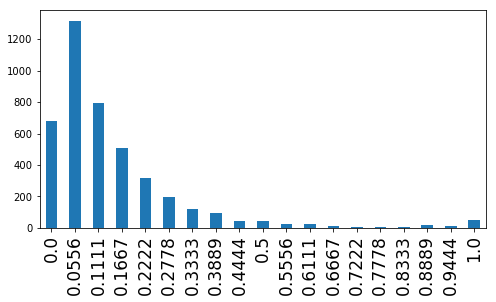

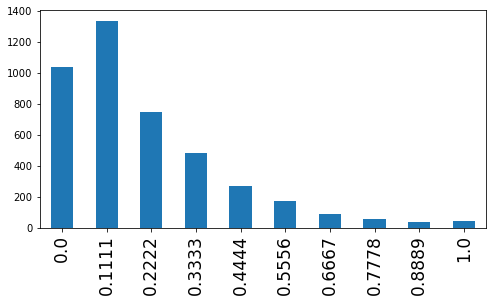

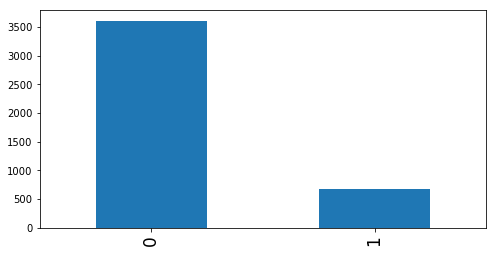

In [84]:
f1 = "languageCounter"
f2 = "popularLanguageCounter"
f3 = "hasLanguage"

csv[languages] = csv_org[languages]
csv[f1] = csv[languages].count(axis=1)
csv[f2] = csv[popularLanguages].count(axis=1)
for l in languages:
    if l in popularLanguages:
        continue
    delete(l)

csv[popularLanguages] = csv[popularLanguages].fillna(0)

csv[f1] = cast(csv[f1],-100,csv[f1].quantile(0.99))
csv[f1] = standarize(csv[f1])
plot(csv[f1].sort_values(),sort=False,log=False,fontsize=17,small=True)


csv[f2] = cast(csv[f2],-100,csv[f2].quantile(0.99))
csv[f2] = standarize(csv[f2])
plot(csv[f2].sort_values(),sort=False,log=False,fontsize=17,small=True)

csv[f3]= csv[f1]>0.0
csv[f3] = factorize(csv[f3])
plot(csv[f3].sort_values(),sort=False,log=False,fontsize=17,small=True)

In [87]:
to_delete = ("_created", "_processed", "Unnamed: 0", "name", "isDisabled", "isLocked", "isMirror", "isPrivate", "url", "_uri", "assign_company", "stargazer_bio", "stargazer_company", "release_isDraft", "release_isPrerelease", "_error","_error_trace", 'createdAt', 'pushedAt')
for f in to_delete: 
    delete(f)

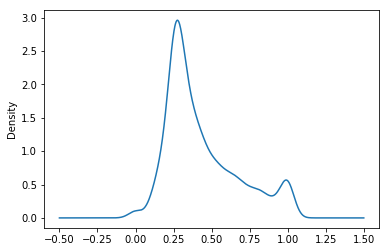

In [65]:
f = "diskUsage"
csv[f] = csv_org[f]
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
csv[f] = csv[f].apply(lambda x: np.power(x,1/5))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

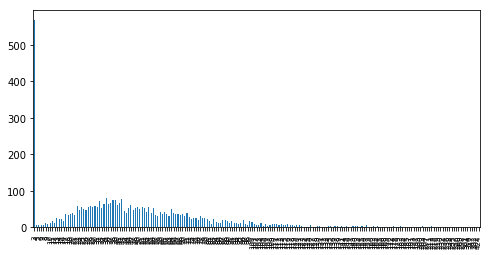

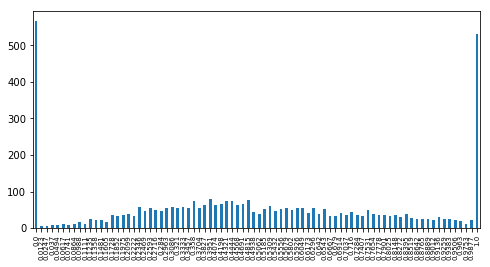

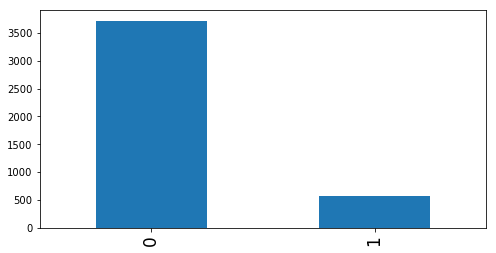

In [67]:
f = "description"
f2 = "description len"
f3 = "has description"
csv[f] = csv_org[f]
csv[f2]= csv[f].astype(str).str.len()
csv[f3]= csv[f2]>3
csv[f3] = factorize(csv[f3])
plot(csv[f2].sort_values(),sort=False,log=False,fontsize=7,small=True)
csv[f2] = cast(csv[f2],-100,2*csv[f2].median())
csv[f2] = standarize(csv[f2])
plot(csv[f2].sort_values(),sort=False,log=False,fontsize=7,small=True)
plot(csv[f3], log=False,fontsize=17,small=True)
delete(f)

In [68]:
f1 = "squashMergeAllowed"
f2 = "isArchived"
csv[f1] = csv_org[f1]
csv[f2] = csv_org[f2]
print(len(csv[csv[f1]==False]))
print(len(csv[csv[f2]==True]))
delete(f1)
delete(f2)

8
79


min: 0.0
max: 166.0
nans: 0
unique: 54
val_type: <class 'numpy.float64'>
vals per class: 79.31


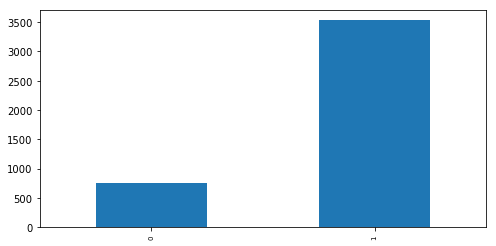

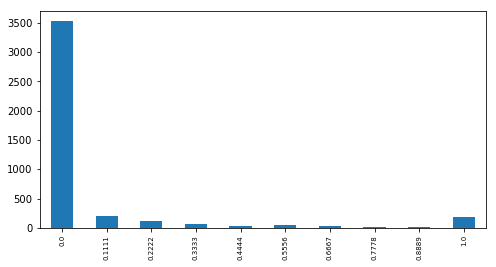

In [71]:
f = "unclosed_issues"
f2 = "has issue"
stat(f)
csv[f] = csv_org[f]

csv[f2]= csv[f]>0
csv[f2] = factorize(csv[f2])
plot(csv[f2], log=False,fontsize=7,small=True)

csv[f] = cast(csv[f],-100,csv[f].quantile(0.96))
csv[f] = standarize(csv[f])

plot(csv[f].sort_values(),sort=False,log=False,fontsize=7, small=True)

min: 0.0
max: 299.0
nans: 0
unique: 190
val_type: <class 'numpy.float64'>
vals per class: 22.54


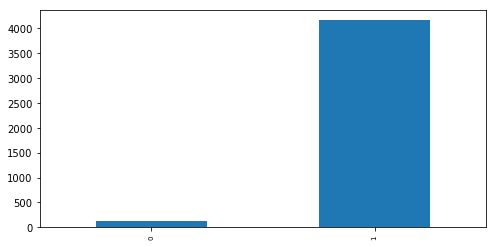

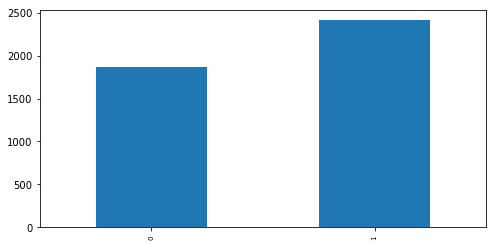

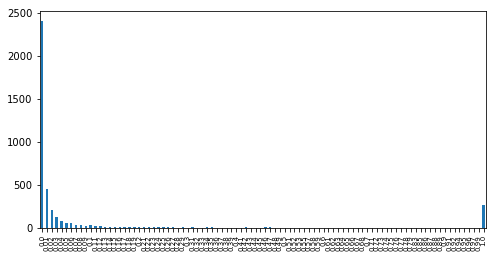

In [72]:
f = "stargazer_"
f2 = "stargazer100"
f3 = "stargazer non zero"

stat(f)
csv[f] = csv_org[f]

csv[f2]= csv[f] == 100.0
csv[f2] = factorize(csv[f2])
plot(csv[f2], log=False,fontsize=7,small=True)

csv[f3]= csv[f] > 0.0
csv[f3] = factorize(csv[f3])
plot(csv[f3], log=False,fontsize=7,small=True)

csv[f] = cast(csv[f],-100,csv[f].quantile(0.96))
csv[f] = standarize(csv[f])

plot(csv[f].sort_values(),sort=False,log=False,fontsize=7, small=True)

min: 0.0
max: 32.0
nans: 0
unique: 19
val_type: <class 'numpy.float64'>
vals per class: 225.42


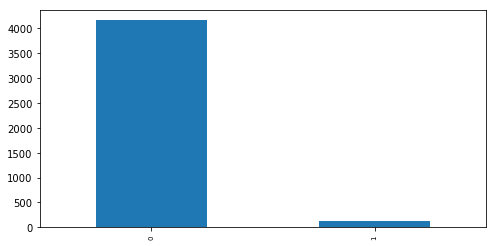

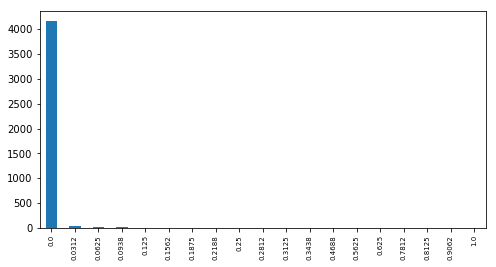

In [73]:
f = "milestone"
f2 = "has milestone"
stat(f)
csv[f] = csv_org[f]

csv[f2]= csv[f]>0.0
csv[f2] = factorize(csv[f2])
plot(csv[f2], log=False,fontsize=7,small=True)

# csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])

plot(csv[f].sort_values(),sort=False,log=False,fontsize=7, small=True)

min: 0.0
max: 31.0
nans: 0
unique: 18
val_type: <class 'numpy.float64'>
vals per class: 237.94


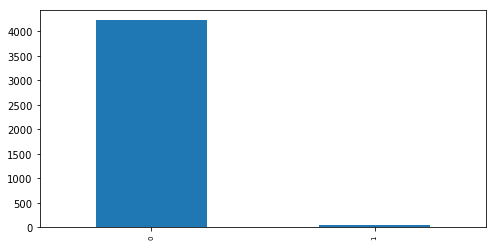

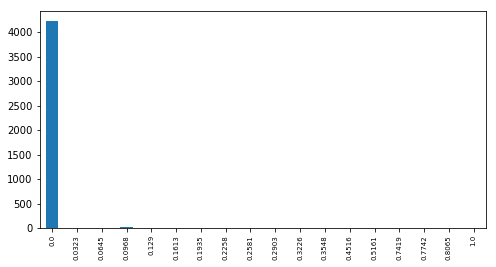

In [74]:
f = "milestone_closed"
f2 = "has milestone"
stat(f)
csv[f] = csv_org[f]

csv[f2]= csv[f]>0.0
csv[f2] = factorize(csv[f2])
plot(csv[f2], log=False,fontsize=7,small=True)

# csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])

plot(csv[f].sort_values(),sort=False,log=False,fontsize=7, small=True)

min: 0.0
max: 100.0
nans: 0
unique: 40
val_type: <class 'numpy.float64'>
vals per class: 107.08


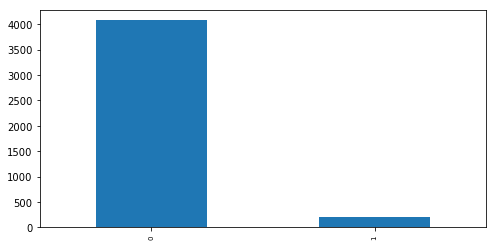

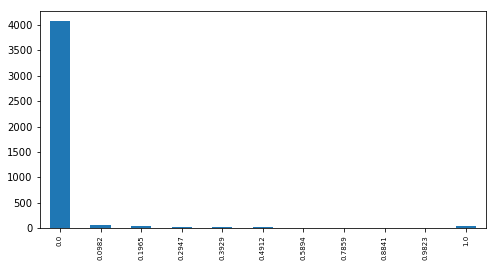

In [75]:
f = "release_"
f2 = "has milestone"
stat(f)
csv[f] = csv_org[f]

csv[f2]= csv[f]>0.0
csv[f2] = factorize(csv[f2])
plot(csv[f2], log=False,fontsize=7,small=True)

csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])

plot(csv[f].sort_values(),sort=False,log=False,fontsize=7, small=True)

1776
2507


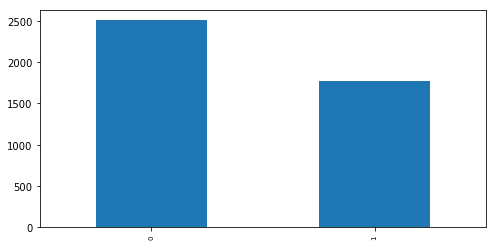

In [78]:
f = "isFork"
print(len(csv[csv[f]==True]))
print(len(csv[csv[f]==False]))
csv[f] = factorize(csv[f])
plot(csv[f].sort_values(),sort=False,log=False,fontsize=7,small=True)

# Save Data

In [90]:
len(csv.columns)

32

In [91]:
csv.to_csv("data.csv", sep=',')